In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import csv
import sdf_helper as sh

def load_density_data(file_path, den_crit=0.17419597124e28):
    data = sh.getdata(file_path)
    ne = data.Derived_Number_Density_Photon.data / den_crit
    # E =  data.Derived_Average_Particle_Energy_Photon.data
    # ne = ne*E
    x = data.Grid_Grid_mid.data[0] / 1e-6
    y = data.Grid_Grid_mid.data[1] / 1e-6
    z = data.Grid_Grid_mid.data[2] / 1e-6
    return ne, x, y, z

def plot_yz_slice(ne, x, y, z, x_range, save=False, output_dir=None):
    mask = (x >= x_range[0]) & (x <= x_range[1])
    ne_sum = np.sum(ne[mask, :, :], axis=0)  # shape: (len(y), len(z))

    Y, Z = np.meshgrid(y, z, indexing='ij')
    plt.figure(figsize=(10, 6))
    c = plt.pcolormesh(Y, Z, ne_sum, shading='auto', cmap="OrRd")
    plt.colorbar(c, label='$n_e / n_c$')
    plt.title(f'YZ slice: x in [{x_range[0]}, {x_range[1]}] μm')
    plt.xlabel('y (μm)')
    plt.ylabel('z (μm)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    return ne_sum

def analyze_centerline_width(ne_sum, y, z, save=False, output_dir=None, x_range=None, sigma=17):
    center_idx = len(y) // 2
    raw_density = ne_sum[center_idx, :]
    y_norm = raw_density / raw_density.max()
    y_smooth = gaussian_filter1d(y_norm, sigma=sigma)

    peaks, _ = find_peaks(y_smooth, height=0.1)  # 得到的是大于0.1的峰值的索引，有很多峰值
    if len(peaks) == 0:
        print("No peak found for centerline density.")
        return None

    peak_idx = peaks[np.argmax(y_smooth[peaks])] # 找到峰值最大的索引
    y_peak = y_smooth[peak_idx]                  # 找到最大峰值
    y_1e = y_peak / np.e

    left = np.where(y_smooth[:peak_idx] < y_1e)[0]  # 峰值的左边索引
    right = np.where(y_smooth[peak_idx:] < y_1e)[0]

    left_idx = left[-1] + 1
    right_idx = right[0] + peak_idx   # right[0]重新开始的索引为0，因此需要加上peak_idx才是之前对应的索引位置
    z_local = z[left_idx:right_idx + 1]
    y_local = y_smooth[left_idx:right_idx + 1]

    f = interp1d(z_local, y_local, kind='cubic')
    z_dense = np.linspace(z_local[0], z_local[-1], 1000)
    y_dense = f(z_dense)
    peak_idx_dense = np.argmax(y_dense) # 找到最大值（峰值）所在的索引（位置）

    left_cross = z_dense[np.where(y_dense[:peak_idx_dense] >= y_1e)[0][0]]  # np.where(...) 返回的是一个元组,所以[0]，后一个就是取第一个到达1/e的位置
    right_cross = z_dense[peak_idx_dense + np.where(y_dense[peak_idx_dense:] >= y_1e)[0][-1]]

    width = right_cross - left_cross

    plt.figure(figsize=(10, 6))
    plt.plot(z, y_norm, '.', alpha=0.5, label='Raw')
    plt.plot(z, y_smooth, 'b-', label='Smoothed')
    plt.axhline(y=y_1e, color='gray', linestyle='--', label='1/e level')
    plt.axvline(left_cross, color='red', linestyle='-', label='1/e width')
    plt.axvline(right_cross, color='red', linestyle='-')
    plt.title('Center Line Profile & 1/e Width')
    plt.xlabel('z (μm)')
    plt.ylabel('Normalized $n_e$')
    plt.legend()
    if save and output_dir and x_range:
        plt.savefig(os.path.join(output_dir, f"centerline_x_{x_range[0]}_{x_range[1]}.jpg"), dpi=300, bbox_inches='tight')
    plt.show()

    return {'width': width, 'left': left_cross, 'right': right_cross}

def plot_zoomed_density(ne, x, y, z, x_range, z_bounds, save=False, output_dir=None):
    y_bounds = z_bounds
    x_mask = (x >= x_range[0]) & (x <= x_range[1])
    y_mask = (y >= y_bounds[0]) & (y <= y_bounds[1])
    z_mask = (z >= z_bounds[0]) & (z <= z_bounds[1])

    # 获取索引以适配 np.ix_
    x_idx = np.where(x_mask)[0]
    y_idx = np.where(y_mask)[0]
    z_idx = np.where(z_mask)[0]

    ne_zoom = ne[np.ix_(x_idx, y_idx, z_idx)]
    ne_sum_zoom = np.sum(ne_zoom, axis=0)

    Y, Z = np.meshgrid(y[y_idx], z[z_idx], indexing='ij')
    plt.figure(figsize=(10, 6))
    c = plt.pcolormesh(Y, Z, ne_sum_zoom, shading='auto', cmap="OrRd")
    plt.colorbar(c, label='$n_e / n_c$')
    plt.title(f'Zoomed Region: x={x_range}, y=±2, z=1/e')
    plt.xlabel('y (μm)')
    plt.ylabel('z (μm)')
    if save and output_dir:
        plt.savefig(os.path.join(output_dir, f"zoomed_x_{x_range[0]}_{x_range[1]}.jpg"), dpi=300, bbox_inches='tight')
    plt.show()

    total_density = np.sum(ne_sum_zoom)
    print(f"Total normalized density: {total_density:.4e}")
    return total_density

def analyze_region(file_path, x_range, save=True, output_dir=None, save_csv=False, csv_path=None):
    ne, x, y, z = load_density_data(file_path)
    ne_sum = plot_yz_slice(ne, x, y, z, x_range, save, output_dir) #画出投影图
    width_info = analyze_centerline_width(ne_sum, y, z, save, output_dir, x_range)
    if width_info is None:
        print("Failed to analyze 1/e width.")
        return

    total = plot_zoomed_density(ne, x, y, z, x_range, (width_info['left'], width_info['right']), save, output_dir)

    result = {
        "x_range": x_range,
        "1e_width": width_info['width'],
        "left": width_info['left'],
        "right": width_info['right'],
        "total_density": total
    }

    if save_csv and csv_path:
        with open(csv_path, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([x_range[0], x_range[1], width_info['width'], width_info['left'], width_info['right'], total])

    return result

if __name__ == "__main__":
    file_path = os.path.join(
        # '/media/lan/4248e56e-6d9a-4026-afad-e8b1d59ceab0/epoch-set2/epoch3d/ju2024ab+2/10kev25磁场',
        '/media/lan/4248e56e-6d9a-4026-afad-e8b1d59ceab0/epoch-set2/epoch3d/ju2024abx0/10kev无磁场',
        'density0018.sdf'
    )

    output_dir = './output'
    os.makedirs(output_dir, exist_ok=True)

    x_ranges = [(16.5, 17.2), (17.2, 17.9), (17.9, 18.7), (18.7, 19.5),(19.5,20.4),(20.4,21.2),(21.2,22),(22,22.8),(22.8,23.5),(23.5,24.3)]
    # x_ranges = [(18, 19),(19, 19.7), (19.7, 20.4), (20.4, 21.2),(21.2,22),(22,22.7),(22.7,23.5)] 
    csv_path = os.path.join(output_dir, '密度0磁场平滑18-results.csv')

    # 写入表头（若文件不存在）
    if not os.path.exists(csv_path):
        with open(csv_path, 'w', newline='') as f:
            csv.writer(f).writerow(['x_min', 'x_max', '1e_width(um)', 'z_left(um)', 'z_right(um)', 'total_density'])

    # 分析每个区域
    for x_min, x_max in x_ranges:
        result = analyze_region(file_path, (x_min, x_max), save=False, output_dir=output_dir, save_csv=True, csv_path=csv_path)
        if result:
            print(f"x ∈ ({x_min}, {x_max}) → width = {result['1e_width']:.2f} μm, total = {result['total_density']:.2e}")

Reading file /media/lan/4248e56e-6d9a-4026-afad-e8b1d59ceab0/epoch-set2/epoch3d/ju2024abx0/10kev无磁场/density0018.sdf
t() = time
x(1501, 1001, 1001) = grid
y(1501, 1001, 1001) = grid
z(1501, 1001, 1001) = grid
xc(1500, 1000, 1000) = grid_mid
yc(1500, 1000, 1000) = grid_mid
zc(1500, 1000, 1000) = grid_mid


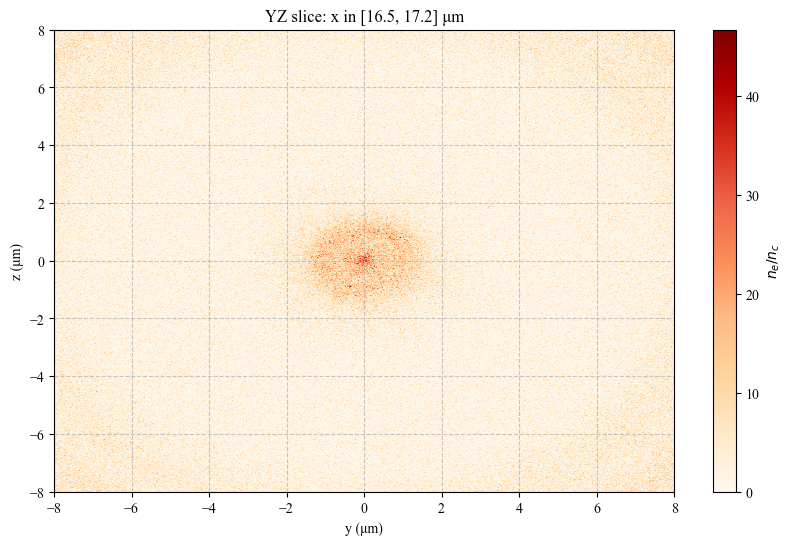

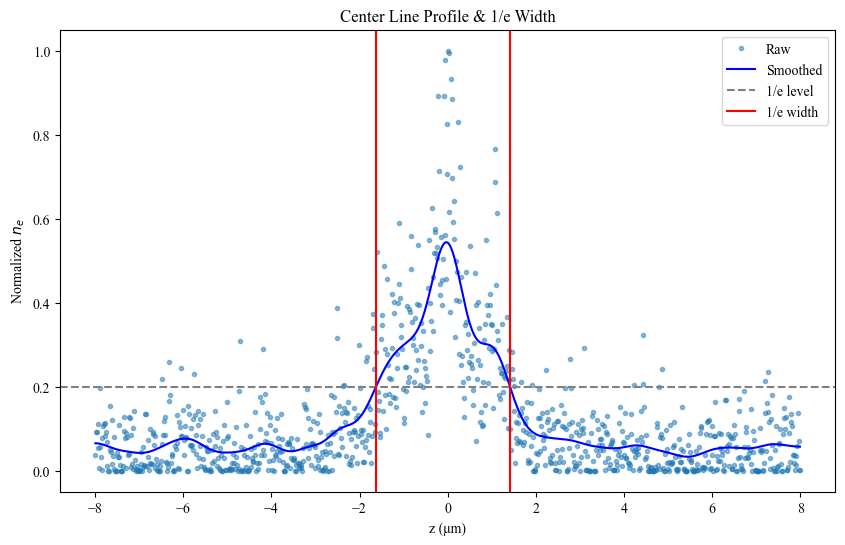

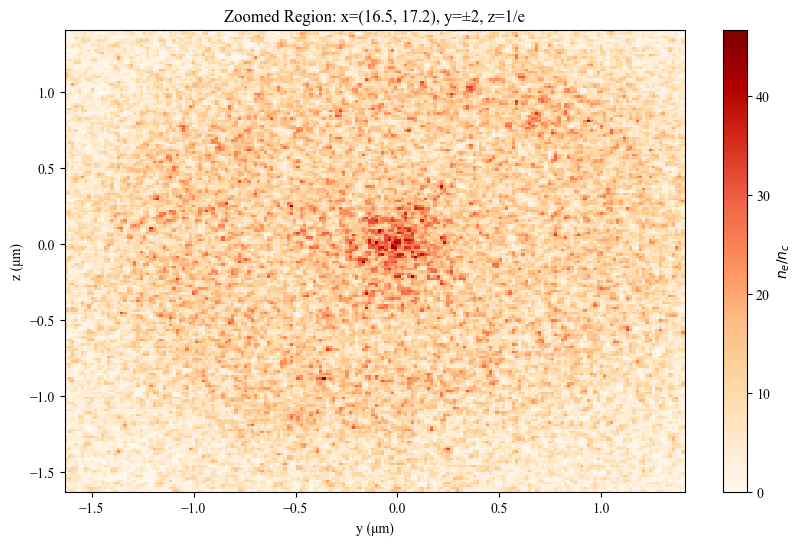

Total normalized density: 3.6003e+05
x ∈ (16.5, 17.2) → width = 3.04 μm, total = 3.60e+05


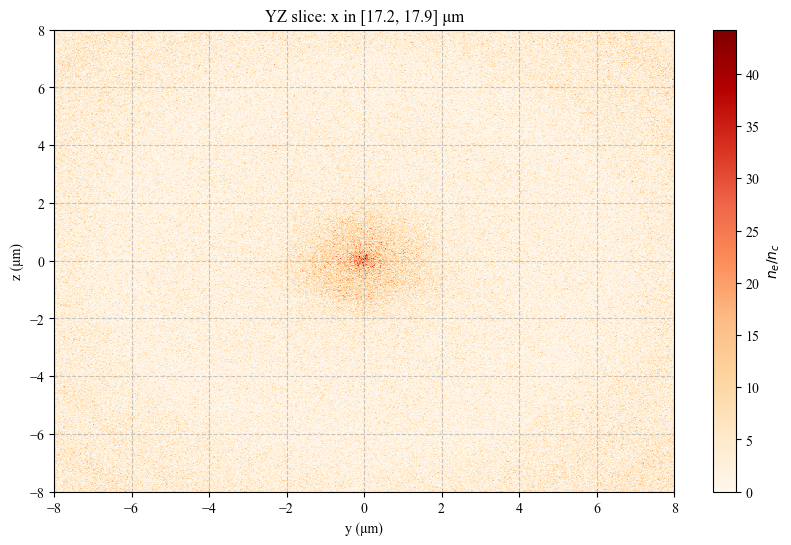

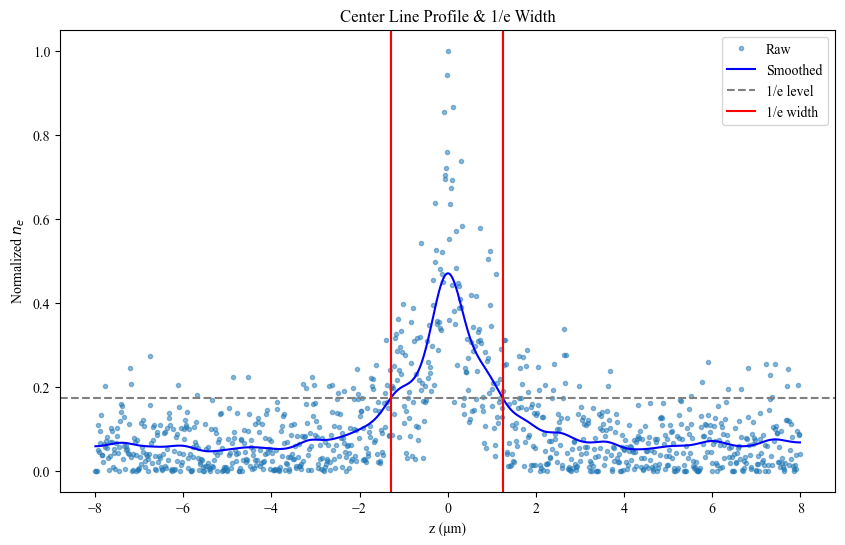

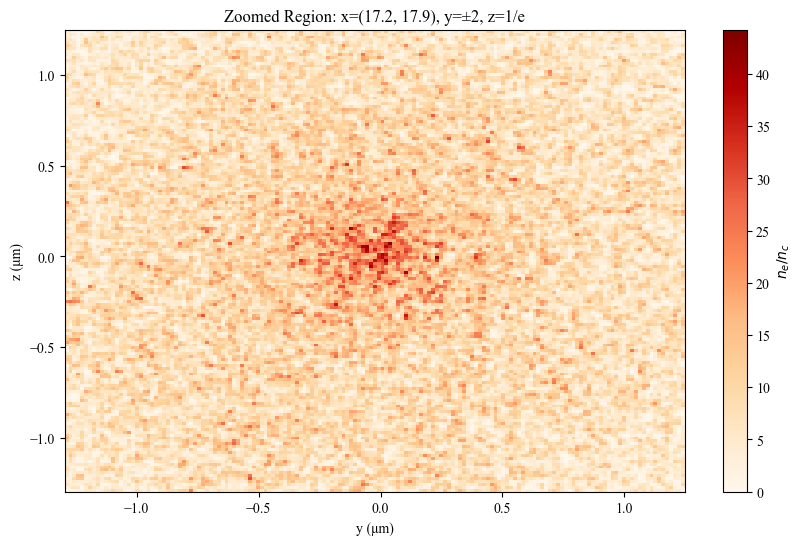

Total normalized density: 2.2281e+05
x ∈ (17.2, 17.9) → width = 2.53 μm, total = 2.23e+05


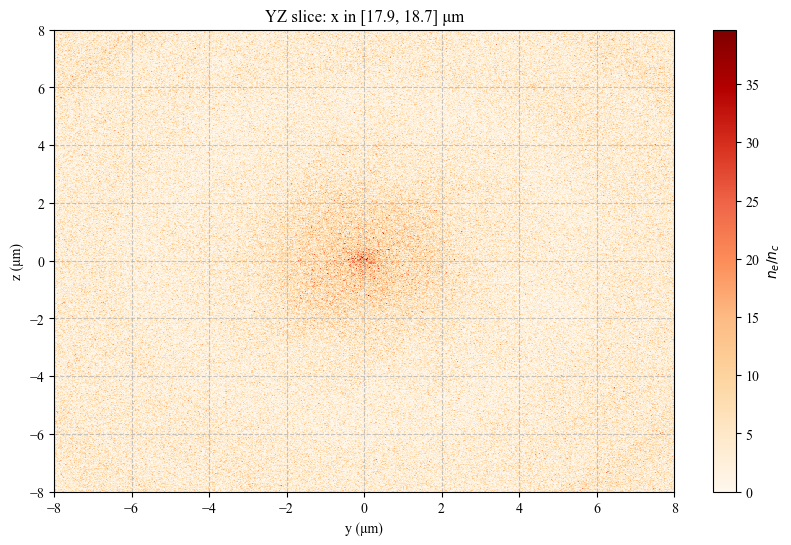

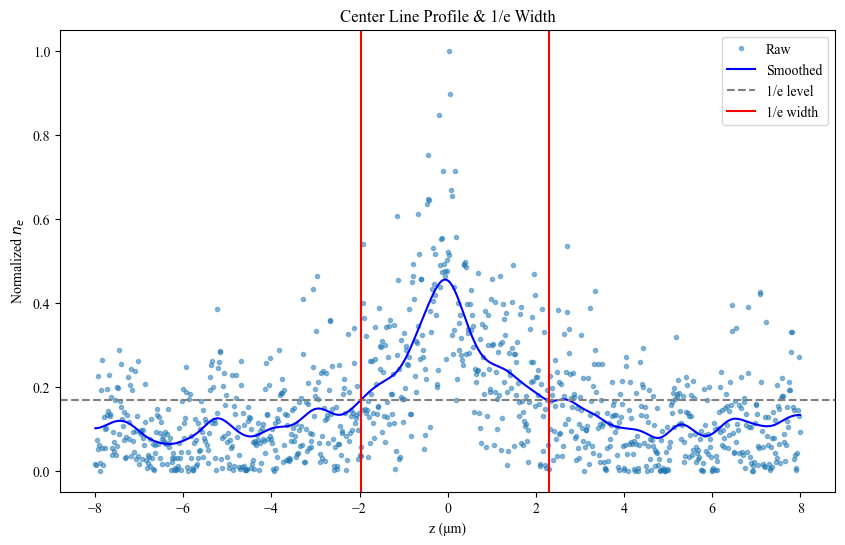

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import csv
import sdf_helper as sh

def load_density_data(file_path, den_crit=0.17419597124e28):
    data = sh.getdata(file_path)
    ne = data.Derived_Number_Density_Photon.data / den_crit
    x = data.Grid_Grid_mid.data[0] / 1e-6
    y = data.Grid_Grid_mid.data[1] / 1e-6
    z = data.Grid_Grid_mid.data[2] / 1e-6

    # 确认能量变量名是否正确
    ek = data.Derived_Average_Particle_Energy_Photon.data

    return ne, ek, x, y, z

def plot_yz_slice(ne, x, y, z, x_range, save=False, output_dir=None):
    mask = (x >= x_range[0]) & (x <= x_range[1])
    ne_sum = np.sum(ne[mask, :, :], axis=0)  # shape: (len(y), len(z))

    Y, Z = np.meshgrid(y, z, indexing='ij')
    plt.figure(figsize=(10, 6))
    c = plt.pcolormesh(Y, Z, ne_sum, shading='auto', cmap="OrRd")
    plt.colorbar(c, label='$n_e / n_c$')
    plt.title(f'YZ slice: x in [{x_range[0]}, {x_range[1]}] μm')
    plt.xlabel('y (μm)')
    plt.ylabel('z (μm)')
    plt.grid(True, linestyle='--', alpha=0.7)
    if save and output_dir:
        plt.savefig(os.path.join(output_dir, f"yz_slice_x_{x_range[0]}_{x_range[1]}.jpg"), dpi=300, bbox_inches='tight')
    plt.show()
    return ne_sum

def analyze_centerline_width(ne_sum, y, z, save=False, output_dir=None, x_range=None, sigma=17):
    center_idx = len(y) // 2
    raw_density = ne_sum[center_idx, :]
    y_norm = raw_density / raw_density.max()
    y_smooth = gaussian_filter1d(y_norm, sigma=sigma)

    peaks, _ = find_peaks(y_smooth, height=0.1)
    if len(peaks) == 0:
        print("No peak found for centerline density.")
        return None

    peak_idx = peaks[np.argmax(y_smooth[peaks])]
    y_peak = y_smooth[peak_idx]
    y_1e = y_peak / np.e

    left = np.where(y_smooth[:peak_idx] < y_1e)[0]
    right = np.where(y_smooth[peak_idx:] < y_1e)[0]

    left_idx = left[-1] + 1 if len(left) > 0 else 0
    right_idx = right[0] + peak_idx if len(right) > 0 else len(z) - 1

    z_local = z[left_idx:right_idx + 1]
    y_local = y_smooth[left_idx:right_idx + 1]

    f = interp1d(z_local, y_local, kind='cubic')
    z_dense = np.linspace(z_local[0], z_local[-1], 1000)
    y_dense = f(z_dense)
    peak_idx_dense = np.argmax(y_dense)

    left_cross = z_dense[np.where(y_dense[:peak_idx_dense] >= y_1e)[0][0]]
    right_cross = z_dense[peak_idx_dense + np.where(y_dense[peak_idx_dense:] >= y_1e)[0][-1]]

    width = right_cross - left_cross

    plt.figure(figsize=(10, 6))
    plt.plot(z, y_norm, '.', alpha=0.5, label='Raw')
    plt.plot(z, y_smooth, 'b-', label='Smoothed')
    plt.axhline(y=y_1e, color='gray', linestyle='--', label='1/e level')
    plt.axvline(left_cross, color='red', linestyle='-', label='1/e width')
    plt.axvline(right_cross, color='red', linestyle='-')
    plt.title('Center Line Profile & 1/e Width')
    plt.xlabel('z (μm)')
    plt.ylabel('Normalized $n_e$')
    plt.legend()
    if save and output_dir and x_range:
        plt.savefig(os.path.join(output_dir, f"centerline_x_{x_range[0]}_{x_range[1]}.jpg"), dpi=300, bbox_inches='tight')
    plt.show()

    return {'width': width, 'left': left_cross, 'right': right_cross}

def plot_zoomed_density(ne, x, y, z, x_range, z_bounds, save=False, output_dir=None):
    y_bounds = (y[0], y[-1])  # 全部 y 范围
    x_mask = (x >= x_range[0]) & (x <= x_range[1])
    y_mask = (y >= y_bounds[0]) & (y <= y_bounds[1])
    z_mask = (z >= z_bounds[0]) & (z <= z_bounds[1])

    x_idx = np.where(x_mask)[0]
    y_idx = np.where(y_mask)[0]
    z_idx = np.where(z_mask)[0]

    ne_zoom = ne[np.ix_(x_idx, y_idx, z_idx)]
    ne_sum_zoom = np.sum(ne_zoom, axis=0)

    Y, Z = np.meshgrid(y[y_idx], z[z_idx], indexing='ij')
    plt.figure(figsize=(10, 6))
    c = plt.pcolormesh(Y, Z, ne_sum_zoom, shading='auto', cmap="OrRd")
    plt.colorbar(c, label='$n_e / n_c$')
    plt.title(f'Zoomed Region: x={x_range}, z={z_bounds}')
    plt.xlabel('y (μm)')
    plt.ylabel('z (μm)')
    if save and output_dir:
        plt.savefig(os.path.join(output_dir, f"zoomed_x_{x_range[0]}_{x_range[1]}.jpg"), dpi=300, bbox_inches='tight')
    plt.show()

    total_density = np.sum(ne_sum_zoom)
    print(f"Total normalized density: {total_density:.4e}")
    return total_density

def energy_stats_in_region(ek, x, y, z, x_range, y_range, z_range):
    x_idx = np.where((x >= x_range[0]) & (x <= x_range[1]))[0]
    y_idx = np.where((y >= y_range[0]) & (y <= y_range[1]))[0]
    z_idx = np.where((z >= z_range[0]) & (z <= z_range[1]))[0]

    if len(x_idx) == 0 or len(y_idx) == 0 or len(z_idx) == 0:
        print(f"Empty index range for energy stats in x:{x_range}, y:{y_range}, z:{z_range}")
        return None, None

    subset = ek[np.ix_(x_idx, y_idx, z_idx)]
    var = np.var(subset)
    mean = np.mean(subset)
    return var, mean

def ne_stats_in_region(ne, x, y, z, x_range, y_range, z_range):
    x_idx = np.where((x >= x_range[0]) & (x <= x_range[1]))[0]
    y_idx = np.where((y >= y_range[0]) & (y <= y_range[1]))[0]
    z_idx = np.where((z >= z_range[0]) & (z <= z_range[1]))[0]

    if len(x_idx) == 0 or len(y_idx) == 0 or len(z_idx) == 0:
        print(f"Empty index range for ne stats in x:{x_range}, y:{y_range}, z:{z_range}")
        return None, None, None

    subset = ne[np.ix_(x_idx, y_idx, z_idx)]
    total = np.sum(subset)
    mean = np.mean(subset)
    variance = np.var(subset)
    return total, mean, variance

def analyze_region(file_path, x_range, save=True, output_dir=None, save_csv=False, csv_path=None):
    ne, ek, x, y, z = load_density_data(file_path)
    ne_sum = plot_yz_slice(ne, x, y, z, x_range, save, output_dir)
    width_info = analyze_centerline_width(ne_sum, y, z, save, output_dir, x_range)
    if width_info is None:
        print("Failed to analyze 1/e width.")
        return

    z_left, z_right = width_info['left'], width_info['right']
    y_range = (y[0], y[-1])  # 全y范围

    # 统计能量
    var_full, mean_full = energy_stats_in_region(ek, x, y, z, x_range, y_range, (z[0], z[-1]))
    var_1e, mean_1e = energy_stats_in_region(ek, x, y, z, x_range, y_range, (z_left, z_right))

    # 统计ne
    ne_total_full, ne_mean_full, ne_var_full = ne_stats_in_region(ne, x, y, z, x_range, y_range, (z[0], z[-1]))
    ne_total_1e, ne_mean_1e, ne_var_1e = ne_stats_in_region(ne, x, y, z, x_range, y_range, (z_left, z_right))

    total_density = plot_zoomed_density(ne, x, y, z, x_range, (z_left, z_right), save, output_dir)

    result = {
        "x_range": x_range,
        "1e_width": width_info['width'],
        "z_left": z_left,
        "z_right": z_right,
        "total_density": total_density,
        "energy_variance_full": var_full,
        "energy_mean_full": mean_full,
        "energy_variance_1e": var_1e,
        "energy_mean_1e": mean_1e,
        "ne_total_full": ne_total_full,
        "ne_mean_full": ne_mean_full,
        "ne_var_full": ne_var_full,
        "ne_total_1e": ne_total_1e,
        "ne_mean_1e": ne_mean_1e,
        "ne_var_1e": ne_var_1e
    }

    if save_csv and csv_path:
        with open(csv_path, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                x_range[0], x_range[1], width_info['width'], z_left, z_right, total_density,
                var_full, mean_full, var_1e, mean_1e,
                ne_total_full, ne_mean_full, ne_var_full,
                ne_total_1e, ne_mean_1e, ne_var_1e
            ])

    return result

if __name__ == "__main__":
    file_path = os.path.join(
        '/media/lan/4248e56e-6d9a-4026-afad-e8b1d59ceab0/epoch-set2/epoch3d/ju2024abx0/10kev无磁场',
        'density0018.sdf'
    )

    output_dir = './output'
    os.makedirs(output_dir, exist_ok=True)

    x_ranges = [(16.5, 17.2), (17.2, 17.9), (17.9, 18.7), (18.7, 19.5), (19.5, 20.4),
                (20.4, 21.2), (21.2, 22), (22, 22.8), (22.8, 23.5), (23.5, 24.3)]

    csv_path = os.path.join(output_dir, '密度0磁场平滑18-results.csv')

    # 写入表头（如果文件不存在）
    if not os.path.exists(csv_path):
        with open(csv_path, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                'x_min', 'x_max', '1e_width(um)', 'z_left(um)', 'z_right(um)', 'total_density',
                'energy_variance_full', 'energy_mean_full', 'energy_variance_1e', 'energy_mean_1e',
                'ne_total_full', 'ne_mean_full', 'ne_var_full',
                'ne_total_1e', 'ne_mean_1e', 'ne_var_1e'
            ])

    for x_min, x_max in x_ranges:
        result = analyze_region(file_path, (x_min, x_max), save=False, output_dir=output_dir, save_csv=True, csv_path=csv_path)
        if result:
            print(f"x ∈ ({x_min}, {x_max}) → 1/e宽度 = {result['1e_width']:.2f} μm, "
                  f"总密度 = {result['total_density']:.2e}, "
                  f"能量方差(全区) = {result['energy_variance_full']:.2e}, 能量均值(全区) = {result['energy_mean_full']:.2e}, "
                  f"能量方差(1/e区) = {result['energy_variance_1e']:.2e}, 能量均值(1/e区) = {result['energy_mean_1e']:.2e}, "
                  f"ne总和(全区) = {result['ne_total_full']:.2e}, ne均值(全区) = {result['ne_mean_full']:.2e}, ne方差(全区) = {result['ne_var_full']:.2e}, "
                  f"ne总和(1/e区) = {result['ne_total_1e']:.2e}, ne均值(1/e区) = {result['ne_mean_1e']:.2e}, ne方差(1/e区) = {result['ne_var_1e']:.2e}")
